# Stochastyczne Automaty Komórkowe

### Importy

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## zad.12
Wykład: https://github.com/houp/ca-class/blob/main/slides/lecture6.pdf

Na wykładzie został pokazany algorytm dekompozycji pLUT na sumę skończenie wielu LUTów. Powiedzieliśmy sobie również, że SCA i 
stochastyczne mikstury to de facto dokładnie to samo - tzn. można łatwo przejść z jednej na drugą reprezentację. 

Napisz dwie funkcje, które dokonują tych zamian:\
**plut_from_mixture**(probabilities, luts) - która zwraca pLUT na podstawie podanych prawdopodobieństw i LUTów,\
**mixture_from_plut**(plut) - która zwraca listę prawdopodobieństw i listę LUTów.
 
Oczywiście musi zachodzić:\
**plut** == plut_from_mixture(mixture_from_plut(plut)).

**plut_from_mixture**(probabilities, luts) -> plut\
Przykład. plut_from_mixture([0.7, 0.3], [ [1,0,1,0,1,0,1,0], [0,0,0,0,0,0,1,1] ]) -> [0.7, 0, 0.7, 0, 0.7, 0, 1, 0.3]

**mixture_from_plut**(plut) -> probabilities, luts\
Przykład. mixture_from_plut([1, 0.9, 0.75, 0.4, 0.5,1, 0, 0.2]) -> [0.5, 0.25, 0.15, 0.05, 0.05], [[1,1,1,0,0,1,0,0], [1,1,0,1,1,1,0,0], [1,1,1,1,1,1,0,1], [1,0,1,0,1,1,0,0], [1,0,1,0,1,1,0,1]]

**Wskazówka.**\
Uważaj na "stabilność numeryczną” albo inaczej niedokładność obliczeń.\
Na komputerze 0.1 + 0.2 nie zawsze równa się 0.3 i 0 to nie zawsze 0.\
Warto co jakiś czas wrzucić w pętli stare dobre print(x) żeby zobaczyć z czym mamy do czynienia.

In [2]:
# wcześniejsze funkcje
def eca_get_lut(rule_num: int) -> np.ndarray:
    return np.array([int(x) for x in bin(rule_num)[2:].zfill(8)], dtype=np.uint8)

def eca_evolve(lut: np.ndarray, x: np.ndarray) -> np.ndarray:
    return lut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]

def eca_evolve_spacetime(lut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(eca_evolve(lut, rows[-1]))
    return np.stack(rows)


In [3]:
# implementacja sca z wykładu
def sca_evolve(plut: np.ndarray, x: np.ndarray) -> np.ndarray:
    probs = plut[7 - (np.roll(x, 1) * 4 + x * 2 + np.roll(x, -1))]
    rnd = np.random.random(size=probs.shape)
    return (rnd<probs).astype(np.int8)

def sca_evolve_spacetime(plut: np.ndarray, initial_conf: np.ndarray, steps: int) -> np.ndarray:
    rows = [initial_conf]
    for _ in range(1, steps):
        rows.append(sca_evolve(plut, rows[-1]))
    return np.stack(rows)

def sca_space_time(plut: np.ndarray, initial_conf: np.ndarray, steps: int):
    spacetime = sca_evolve_spacetime(plut, initial_conf, steps)
    plt.figure(figsize=(5, 5))
    plt.imshow(spacetime, cmap='binary', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    

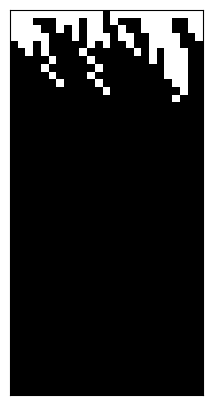

In [4]:
plut = np.array([1, 0.9, 0.75, 0.4, 0.5, 1, 0, 0.2])
sca_space_time(plut, np.array([0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]), 50)

### plut_from_mixture(probabilities, luts) -> plut

In [5]:
def plut_from_mixture(probabilities, luts):
    probabilities = np.array(probabilities)
    luts = np.array(luts)
    plut = np.zeros(8)
    for prob, lut in zip(probabilities, luts):
        plut += prob * lut
    return plut


In [6]:
luts = [eca_get_lut(170), eca_get_lut(3)]
probabilities = [0.7, 0.3]

In [7]:
# plut_from_mixture([0.7, 0.3], [ [1,0,1,0,1,0,1,0], [0,0,0,0,0,0,1,1] ]) -> [0.7, 0, 0.7, 0, 0.7, 0, 1, 0.3]
plut_from_mixture(luts, probabilities)

array([0.7, 0. , 0.7, 0. , 0.7, 0. , 1. , 0.3])

### mixture_from_plut(plut) -> probabilities, luts

In [8]:
def mixture_from_plut(plut):
    probabilities = []
    luts = []
    pi = np.array([1-plut, plut])
    while np.any(pi > 1e-15):
        L = np.zeros_like(pi)
        max_indices = np.argmax(pi, axis=0)
        L[max_indices, np.arange(pi.shape[1])] = 1
        a = np.min(pi[max_indices, np.arange(pi.shape[1])])
        pi = pi - a*L
        probabilities.append(round(a, 2))
        luts.append(np.array(L[1]))
    return probabilities, luts


In [9]:
plut = np.array([1, 0.9, 0.75, 0.4, 0.5, 1, 0, 0.2])

In [10]:
# mixture_from_plut([1, 0.9, 0.75, 0.4, 0.5, 1, 0, 0.2]) -> [0.5, 0.25, 0.15, 0.05, 0.05],
# [[1,1,1,0,0,1,0,0], [1,1,0,1,1,1,0,0], [1,1,1,1,1,1,0,1], [1,0,1,0,1,1,0,0], [1,0,1,0,1,1,0,1]]
mixture_from_plut(plut)

([0.5, 0.25, 0.15, 0.05, 0.05],
 [array([1., 1., 1., 0., 0., 1., 0., 0.]),
  array([1., 1., 0., 1., 1., 1., 0., 0.]),
  array([1., 1., 1., 1., 1., 1., 0., 1.]),
  array([1., 0., 1., 0., 1., 1., 0., 0.]),
  array([1., 0., 1., 0., 1., 1., 0., 1.])])